<a href="https://colab.research.google.com/github/Claptar/spatialMPFC/blob/main/DE/human_young_vs_old_pseudobulk/EdgeR_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies and files

## Install dependencies

In [159]:
!pip install scanpy[leiden] anndata2ri scikit-misc scvi-tools squidpy gseapy decoupler sc-toolbox --quiet

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.6 MB/s eta 0:00:00


## Imports

In [153]:
import warnings
import scanpy as sc
import gseapy
import decoupler
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

Нужно подключить свой гугл диск

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
dir_path = 'drive/MyDrive/Spatial project/results/'

In [156]:
de_dir_path = 'drive/MyDrive/Spatial project/results/DE/young_vs_old_scanpy/'

In [157]:
os.listdir(de_dir_path)

['edgeR', 'scanpy']

### DE results

In [158]:
# Load EdgeR results
edgeR_DE = dict()

for file in os.listdir(de_dir_path + 'edgeR'):
    layer = file.split('_')[0]
    df = pd.read_csv(de_dir_path + 'edgeR/' + file, index_col=0)
    # remove mito hb and rb genes
    mito = df.index.str.startswith('MT-')
    hb = df.index.str.contains(("^HB[AB]"))
    rb = df.index.str.contains(("^RP[LS]"))
    remove = mito | hb | rb
    df = df.loc[~remove]
    
    edgeR_DE[layer] = df

edgeR_DE.keys()

dict_keys(['WM', 'L5', 'L2', 'L3', 'L1', 'L6', 'L4'])

In [159]:
edgeR_DE['L1']

,logFC,logCPM,F,PValue,FDR
NLRP1,-12.290117,7.616894,8.849669e+02,4.300965e-52,5.082880e-48
DPYSL3,3.618613,8.494822,6.061350e+02,1.164502e-45,6.881043e-42
VXN,-11.139452,6.644319,5.611696e+02,2.859678e-43,1.126522e-39
YBX1,3.958872,8.784563,5.298523e+02,4.782240e-43,1.412913e-39
TUBA1A,3.208877,11.739539,4.999432e+02,6.182635e-42,1.461328e-38
...,...,...,...,...,...
HUS1,0.000509,3.249055,1.254909e-06,9.991083e-01,9.992944e-01
TUBGCP2,0.013668,5.847461,9.082083e-03,9.991178e-01,9.992944e-01
UBE2G2,0.000170,5.152333,9.525497e-07,9.992231e-01,9.992944e-01
PGS1,0.059686,4.460213,7.521595e-02,9.992876e-01,9.992944e-01


### Load adata

In [160]:
# read young human adata object
human_young = sc.read_h5ad(dir_path + 'filtered_samples/human.h5ad')
print(human_young)

# add _young sufix to layer name
human_young.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
human_young.obs.label = human_young.obs.label.astype('str') + '_young'

AnnData object with n_obs × n_vars = 15417 × 19966
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'qc_good_spots_colors', 'qc_n_genes_by_counts_colors', 'qc_pct_counts_ribo_colors', 'qc_total_counts_colors', 'spatial'
    obsm: 'spatial'


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [161]:
# read young human adata object
human_old = sc.read_h5ad(dir_path + 'filtered_samples/spatial_libd_human.h5ad')
print(human_old)

# add _young sufix to layer name
human_old.obs.label = human_old.obs.label.astype('str') + '_old'

AnnData object with n_obs × n_vars = 42588 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo'
    uns: 'qc_good_spots_colors', 'qc_n_genes_by_counts_colors', 'qc_pct_counts_mt_colors', 'qc_pct_counts_ribo_colors', 'qc_total_counts_colors', 'spatial'
    obsm: 'spatial'


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [162]:
# concat old and young files
adata = an.concat([human_young, human_old], merge='same',uns_merge="unique")
adata.obs_names_make_unique()
adata

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 58005 × 19404
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'qc_good_spots_colors', 'qc_n_genes_by_counts_colors', 'qc_total_counts_colors', 'spatial', 'qc_pct_counts_mt_colors'
    obsm: 'spatial'

In [163]:
samples = list(adata.uns['spatial'].keys())
samples

['human_759',
 'human_j12',
 'human_j3',
 'human_j4',
 'human_j6',
 '151507',
 '151508',
 '151509',
 '151510',
 '151669',
 '151670',
 '151671',
 '151672',
 '151673',
 '151674',
 '151675',
 '151676']

In [164]:
del human_young, human_old

### Add diff. expr. results to adata

In [165]:
from sc_toolbox.tools import de_res_to_anndata

for layer in edgeR_DE.keys():
    label = layer + '_young'
    df = edgeR_DE[layer]
    df["gene_symbol"] = df.index
    df["label"] = label


    de_res_to_anndata(
            adata,
            df,
            groupby="label",
            score_col="logCPM",
            pval_col="PValue",
            pval_adj_col="FDR",
            lfc_col="logFC",
            key_added="edgeR_" + label,
        )

### Preprocess

In [166]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


In [167]:
sc.pp.highly_variable_genes(
    adata=adata, flavor="seurat", 
    n_top_genes=4000, inplace=True,
    batch_key="sample_id")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:21)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [168]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:39)


In [169]:
mito = adata.var_names.str.startswith('MT-')
hb = adata.var_names.str.contains(("^HB[AB]"))
rb = adata.var_names.str.contains(("^RP[LS]"))
remove = mito | hb | rb
genes_to_remove = adata.var_names[remove].tolist()

keep = np.invert(remove)
print(sum(remove))

de_adata = adata[:,keep]
highly_variable_genes = adata.var[adata.var.highly_variable].index.tolist()

117


# Результаты дифф. экспрессии

In [170]:
def sign_de(de_results):
    sign_dict = dict()
    
    for layer, df in de_results.items():
        sign_dict[layer] = df[df.PValue < 0.05]
    return sign_dict

In [171]:
def de_summary(de_results):
    num, pval05, upreg, downreg = list(), list(), list(), list()

    for layer, df in de_results.items():
        num.append(df.shape[0])
        pval05.append(df[df.PValue < 0.05].shape[0])
        upreg.append(df[(df.PValue < 0.05) & (df.logFC > 0)].shape[0])
        downreg.append(df[(df.PValue < 0.05) & (df.logFC < 0)].shape[0])
    summary = pd.DataFrame([num, pval05, upreg, downreg], columns=de_results.keys(), index=['num', 'pval05', 'upreg', 'downreg'])
    return summary.T

## Простая статистика

In [172]:
de_summary(edgeR_DE)

,num,pval05,upreg,downreg
WM,11707,7419,3711,3708
L5,11707,8179,4309,3870
L2,11707,7572,3901,3671
L3,11707,8368,4464,3904
L1,11707,6711,3386,3325
L6,11707,7931,4188,3743
L4,11707,8143,4287,3856


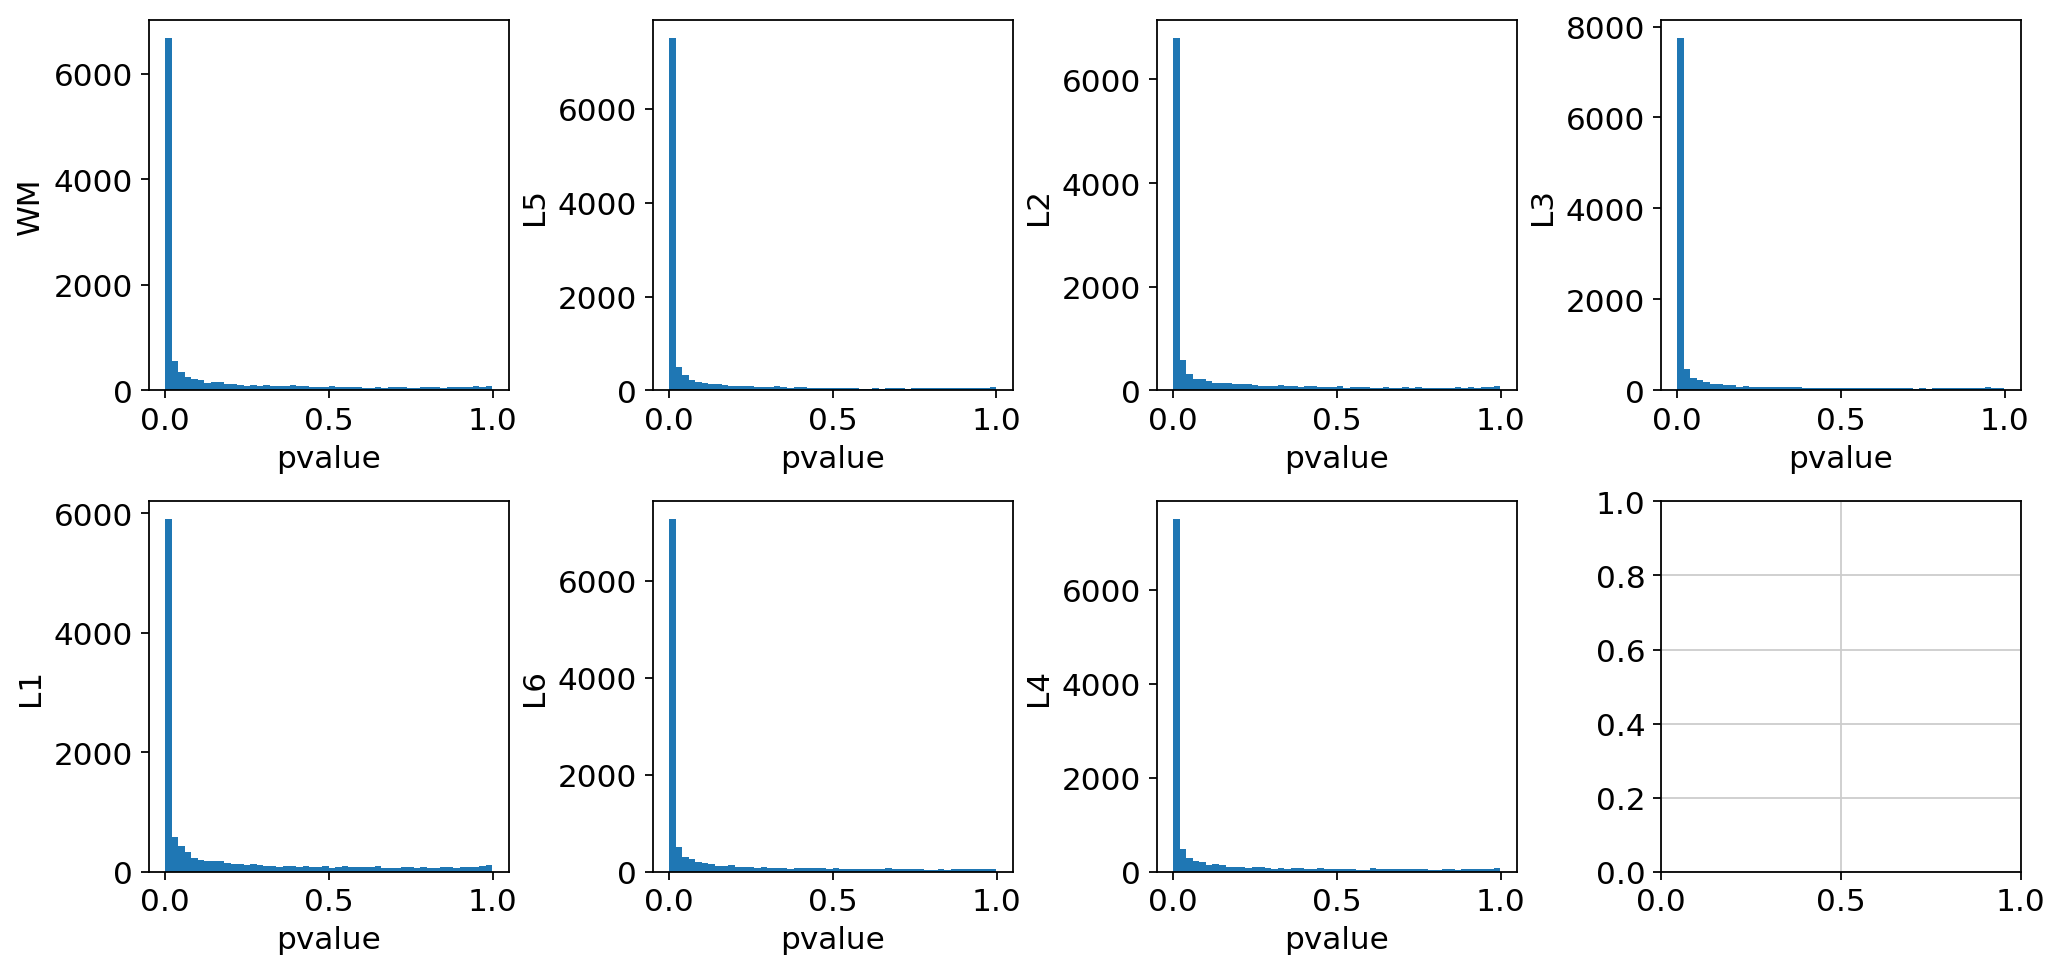

In [173]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7), gridspec_kw={"wspace": 0.4, "hspace": 0.3})
for ax, (layer, df) in zip(axs.reshape(-1), edgeR_DE.items()):
    df.PValue.hist(bins=50, grid=False, ax=ax)
    ax.set_ylabel(layer)
    ax.set_xlabel('pvalue')

## Jacard similarity

In [174]:
# Оставим только значимо дифф. эксп. гены
edgeR_sign = sign_de(edgeR_DE)

In [175]:
# Векторизуем
vectorize_de = pd.concat(edgeR_sign.values(), axis=1).notna().astype(int)['logFC']
vectorize_de.columns = edgeR_sign.keys()
vectorize_de = vectorize_de[["L1", "L2", "L3", "L4", "L5", "L6", "WM"]]
vectorize_de.head()

,L1,L2,L3,L4,L5,L6,WM
NLRP1,1,1,1,1,1,1,1
DPYSL3,1,1,1,1,1,1,1
VXN,1,1,1,1,1,1,1
PTP4A1,1,1,1,1,1,1,1
TUBB2B,1,1,1,1,1,1,1


In [176]:
from sklearn.metrics import DistanceMetric
dist = DistanceMetric.get_metric('jaccard')
pairwise_jaccard = pd.DataFrame(1 - dist.pairwise(vectorize_de.T), columns=vectorize_de.columns, index=vectorize_de.columns)
pairwise_jaccard

,L1,L2,L3,L4,L5,L6,WM
L1,1.000000,0.676408,0.670618,0.657998,0.659978,0.675861,0.615226
L2,0.676408,1.000000,0.773278,0.714488,0.713183,0.706251,0.593601
L3,0.670618,0.773278,1.000000,0.816392,0.801524,0.770091,0.625347
L4,0.657998,0.714488,0.816392,1.000000,0.830436,0.772412,0.622563
L5,0.659978,0.713183,0.801524,0.830436,1.000000,0.817874,0.635353
L6,0.675861,0.706251,0.770091,0.772412,0.817874,1.000000,0.661255
WM,0.615226,0.593601,0.625347,0.622563,0.635353,0.661255,1.000000


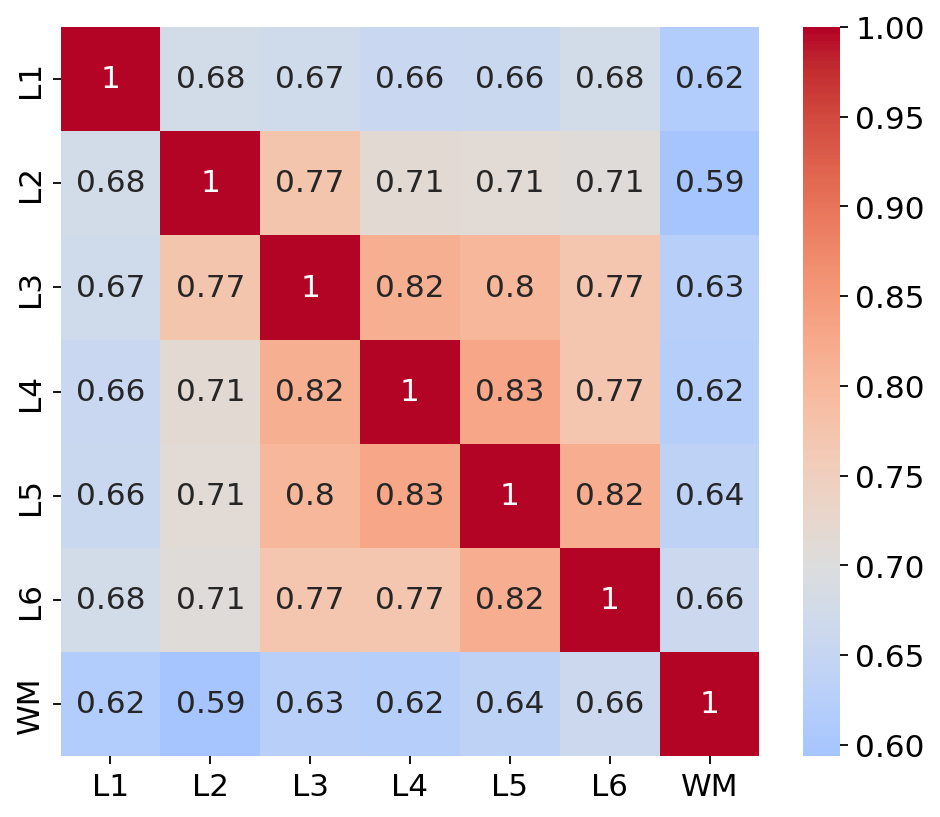

In [177]:
plt.figure(figsize=(7, 6))
sns.heatmap(pairwise_jaccard, annot=True, cmap = 'coolwarm', center=0.7)
plt.grid(False)

In [178]:
common_degenes = edgeR_sign['L1'].index & edgeR_sign['L2'].index & edgeR_sign['L3'].index &\
                 edgeR_sign['L4'].index & edgeR_sign['L5'].index & edgeR_sign['L6'].index & edgeR_sign['WM'].index
common_degenes

Index(['NLRP1', 'DPYSL3', 'VXN', 'YBX1', 'TUBA1A', 'STMN2', 'PTP4A1', 'CXADR',
       'IDS', 'KCNAB2',
       ...
       'PLK3', 'AP3M1', 'OMG', 'ABCC5', 'SLC35A1', 'PREX2', 'ATF3', 'SMARCA2',
       'SDR39U1', 'SENP1'],
      dtype='object', length=4396)

# Визуализация

Нужна функция для подсчёта процента спотов экспрессирующих ген в какой-либо группе

In [179]:
def calculate_pct_group(adata, group):
    for value in adata.obs[group].unique():
        mask = (adata.obs[group] == value)
        value_pct = adata[mask].X.getnnz(axis=0) / adata[mask].X.shape[0]
        adata.var["pct_" + value] = value_pct

In [180]:
calculate_pct_group(adata, 'sample_id')
calculate_pct_group(adata, 'label')
adata.var.head()

,feature_types,mt,hb,ribo,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,...,pct_L1_young,pct_L6_young,pct_L4_young,pct_L1_old,pct_L3_old,pct_WM_old,pct_L6_old,pct_L5_old,pct_L2_old,pct_L4_old
OR4F5,Gene Expression,False,False,False,False,0.000000,0.000000,0.000000,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F29,Gene Expression,False,False,False,False,0.000000,0.000000,0.000000,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OR4F16,Gene Expression,False,False,False,False,0.000000,0.000000,0.000000,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMD11,Gene Expression,False,False,False,True,0.018350,1.512745,0.794882,11,False,...,0.012186,0.003392,0.007692,0.006058,0.004150,0.013336,0.006702,0.005294,0.002559,0.004961
NOC2L,Gene Expression,False,False,False,False,0.379769,1.275595,-0.590589,0,False,...,0.123382,0.254381,0.458242,0.061662,0.145442,0.095884,0.150302,0.178996,0.144424,0.167442


## Общие гены которые отличают молодых от взрослых

Отберем гены, которые являются дифф. экспр. во всех слоях и встречаются в более чем половине спотов образцов

In [182]:
columns = adata.var.columns
sample_id_pct_columns = columns[(columns.str.contains("pct")) & (~columns.str.contains("L"))]
layer_pct_columns = columns[columns.str.contains("L")]

In [186]:
mask = (adata.var[sample_id_pct_columns].min(axis=1) > 0.5)
common_highpct_genes = adata.var.loc[common_degenes][mask].index
common_highpct_genes

<ipython-input-186-f82b2fa134e7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_highpct_genes = adata.var.loc[common_degenes][mask].index


Index(['TUBA1A', 'STMN2', 'STMN1', 'TUBB', 'CKB', 'PSAP', 'TUBB2A', 'UBA52',
       'CCNI', 'RACK1', 'EEF1A1', 'COX4I1', 'GPM6A', 'COX6C', 'BASP1',
       'TMSB10', 'PFDN5', 'TPT1', 'NACA', 'EEF2', 'CLU', 'ATP1B1', 'MAP1B',
       'ACTG1', 'RTN3', 'GAPDH', 'RTN1', 'NDUFA4', 'COX6A1', 'PEBP1', 'GNB1',
       'MAP2', 'MT3', 'GUK1', 'SKP1', 'TMSB4X', 'ITM2B', 'SELENOW', 'SERINC1',
       'ACTB', 'C1orf61', 'EIF1', 'CST3', 'PTMA', 'UBB', 'PPP2R1A', 'DSTN',
       'YWHAZ'],
      dtype='object')

In [205]:
pretty_genes_young = ['TUBA1A','TUBB', 'TUBB2A', 'STMN2', 'STMN1', 'UBA52',
                      'CCNI','RACK1', 'BASP1', 'PFDN5', 'TPT1', 'NACA']

In [206]:
pretty_genes_old = ['CKB', 'PSAP', 'COX4I1', 'COX6C', 'NDUFA4', 'COX6A1', 'PEBP1']

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


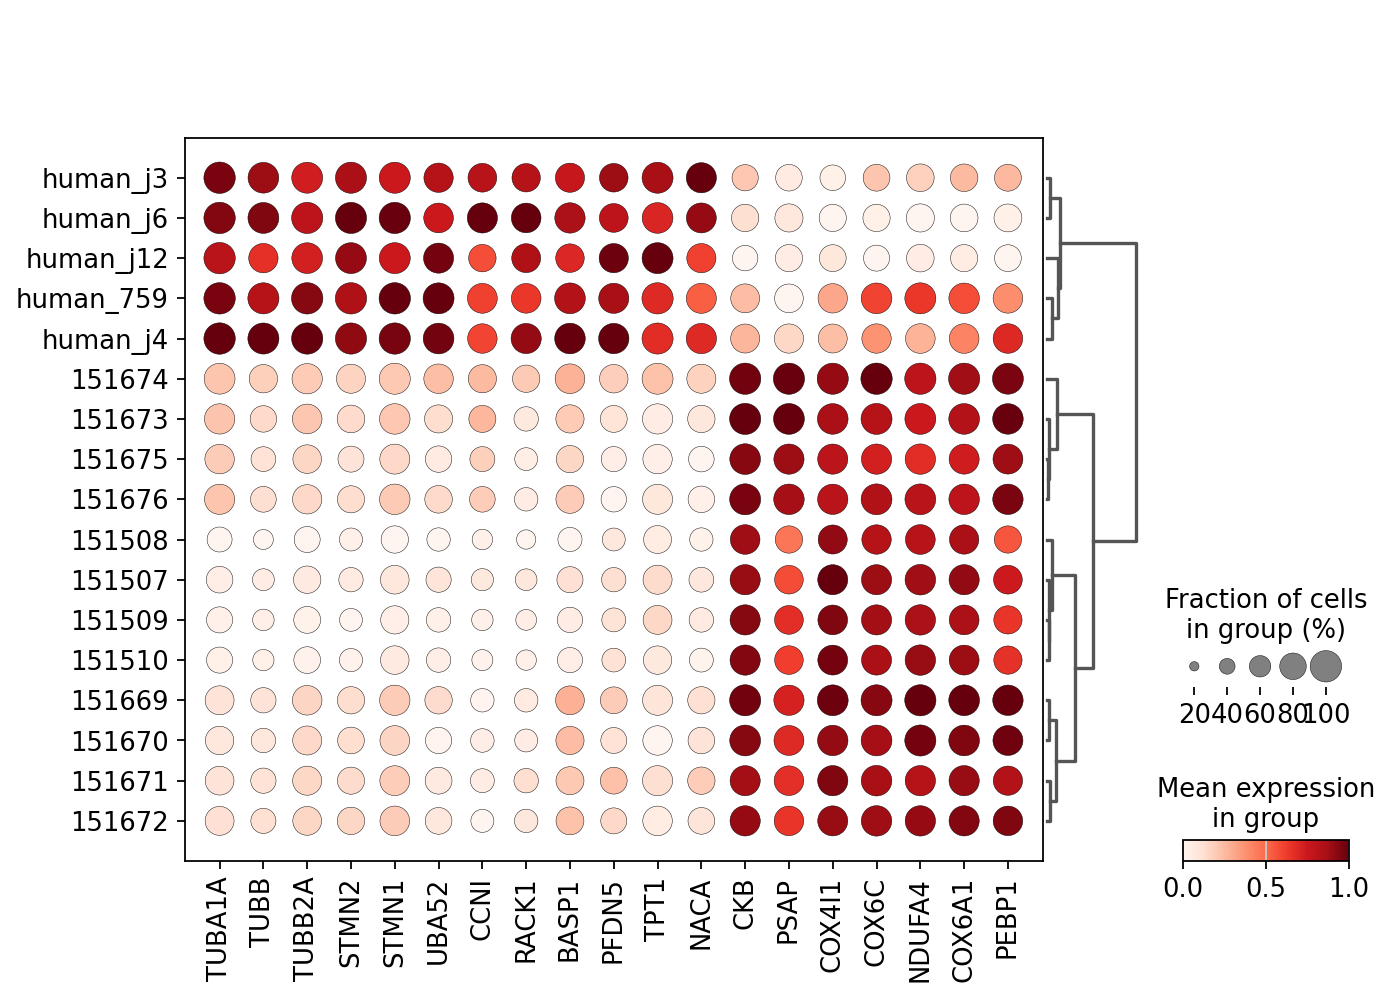

In [226]:
sc.pl.dotplot(adata, pretty_genes_young + pretty_genes_old, groupby='sample_id', standard_scale='var', dendrogram=True)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


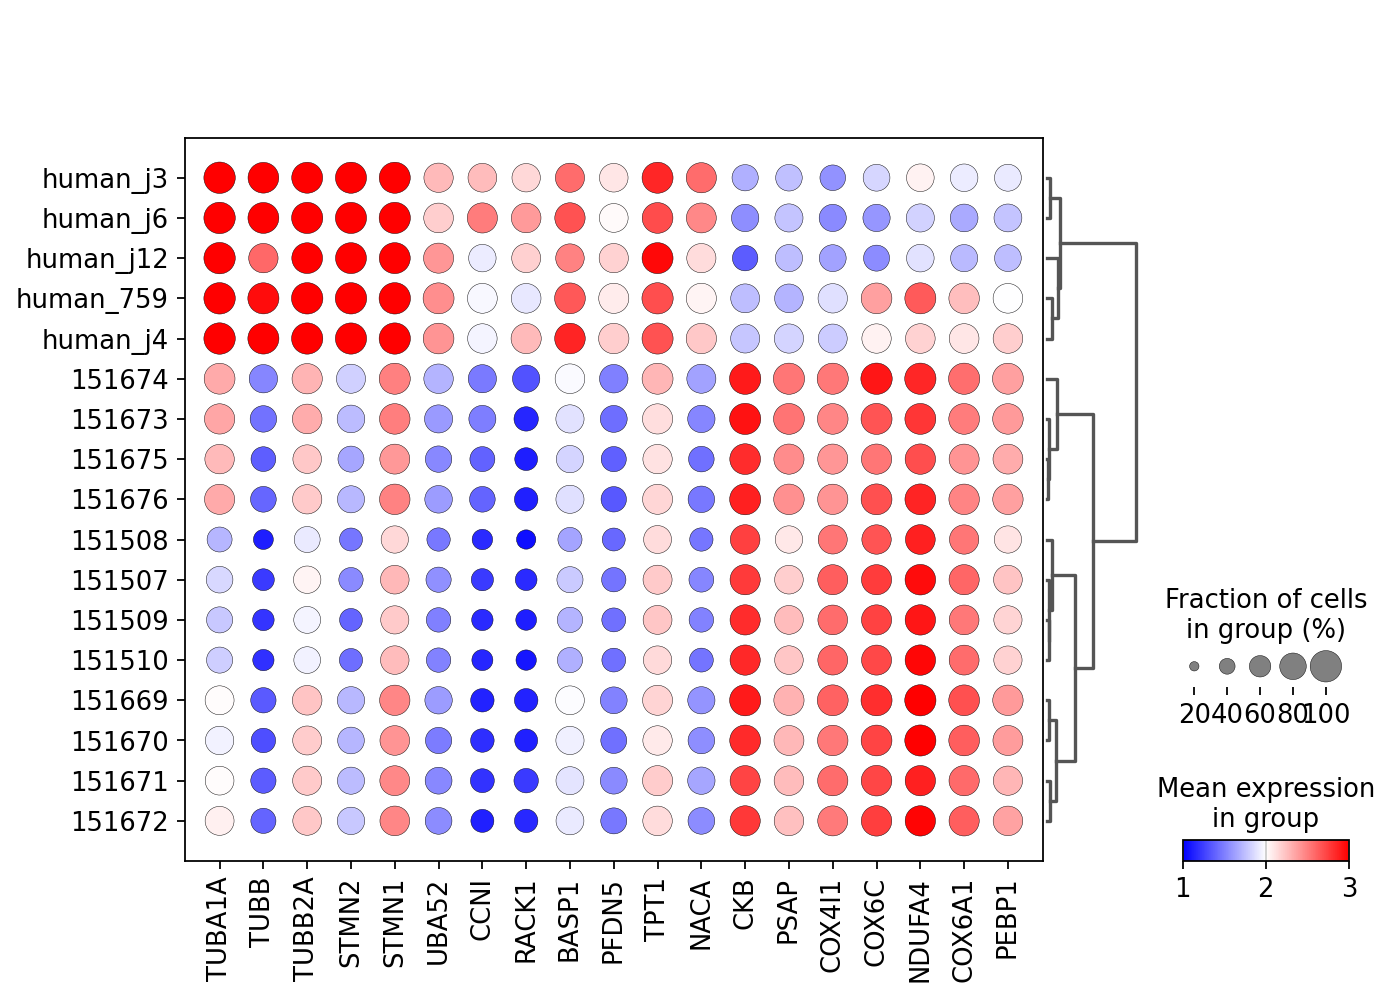

In [230]:
sc.pl.dotplot(adata, pretty_genes_young + pretty_genes_old, groupby='sample_id', cmap='bwr', vmin=1, vmax=3, dendrogram=True)

Заметим, что для некоторых генов `human_759` тянется к взрослым образцам

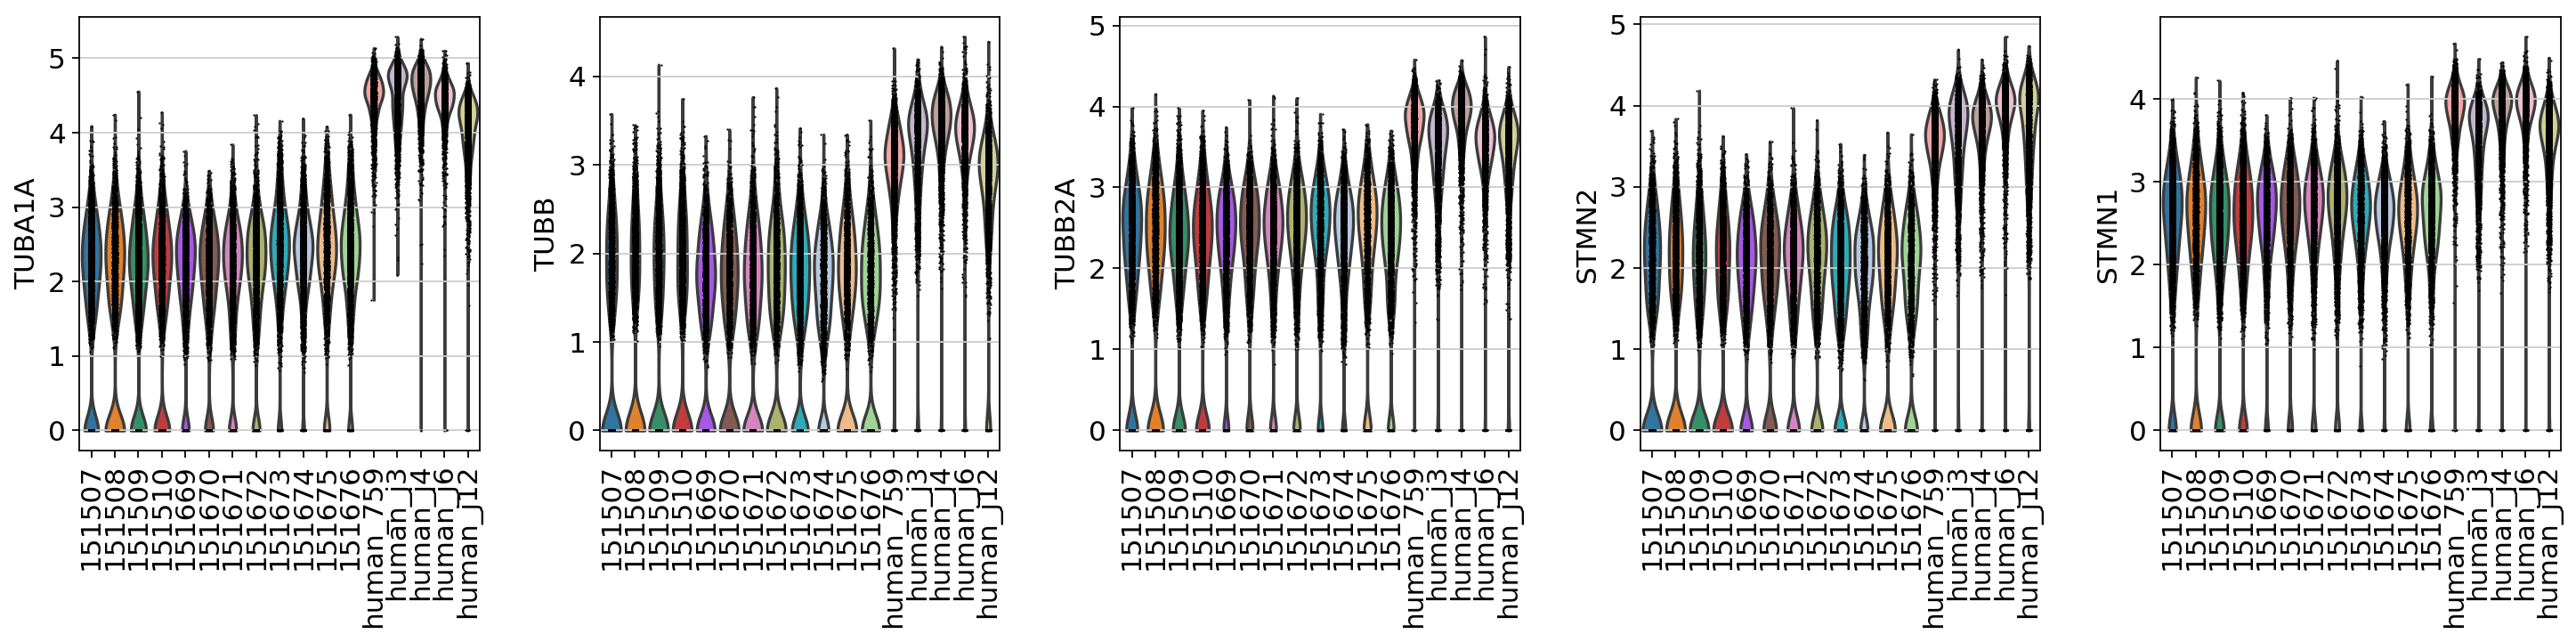

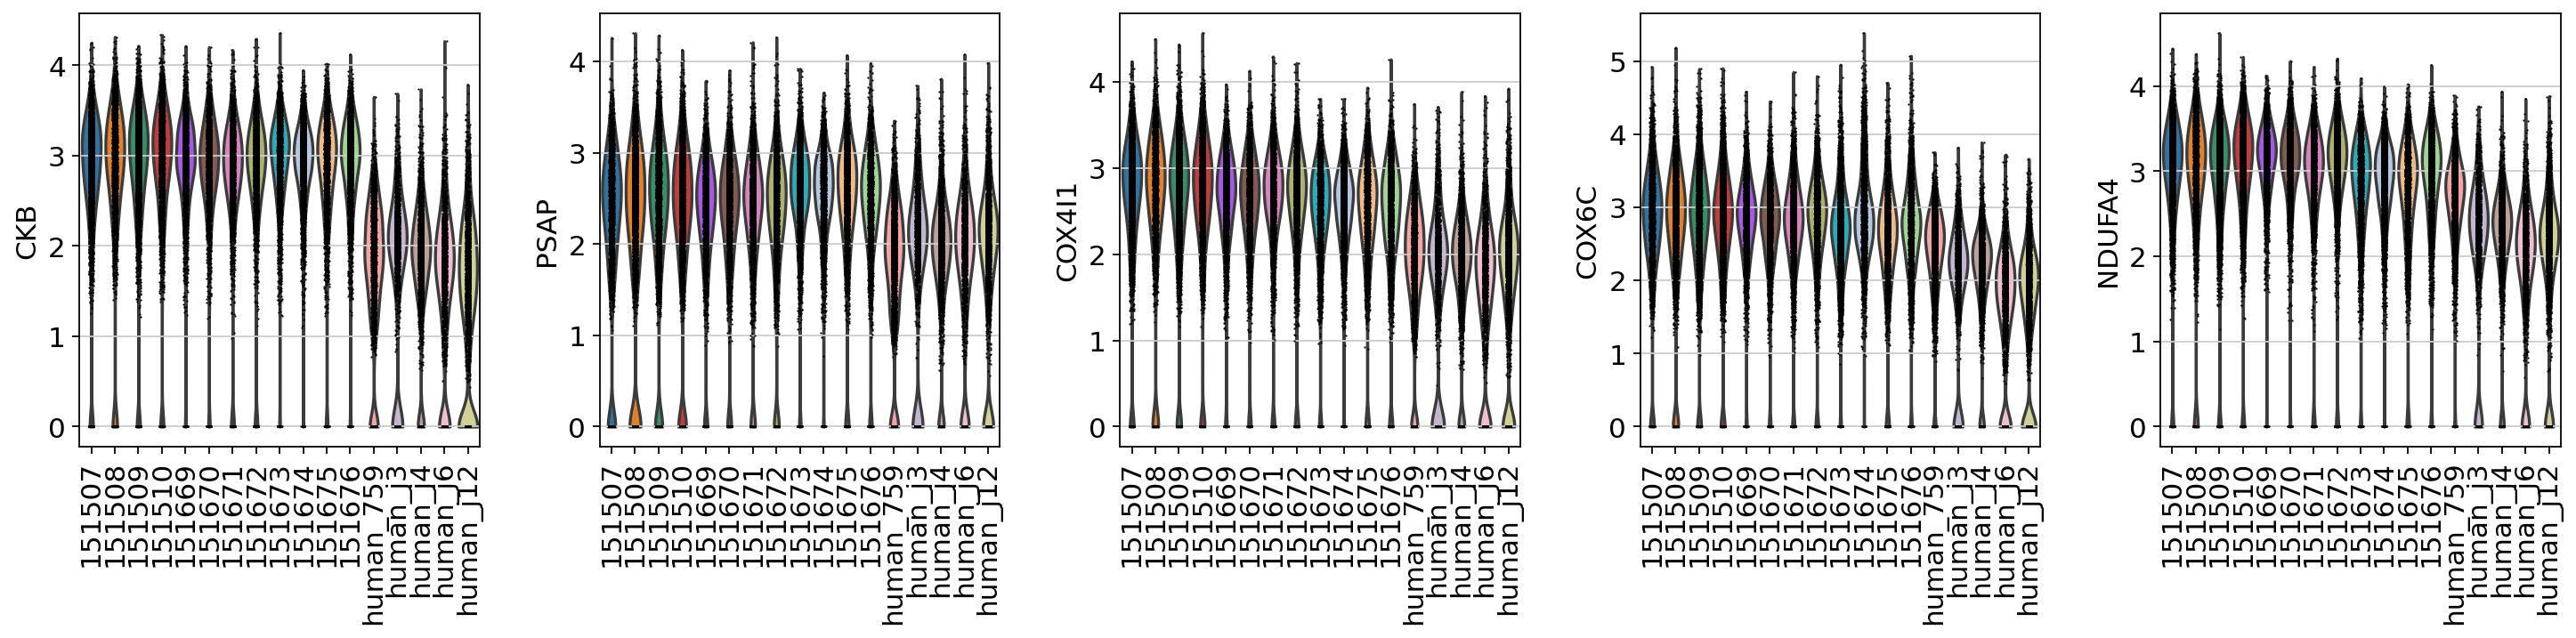

In [212]:
sc.pl.violin(adata, pretty_genes_young[:5], groupby='sample_id', rotation=90)
sc.pl.violin(adata, pretty_genes_old[:5], groupby='sample_id', rotation=90)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_label']`


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


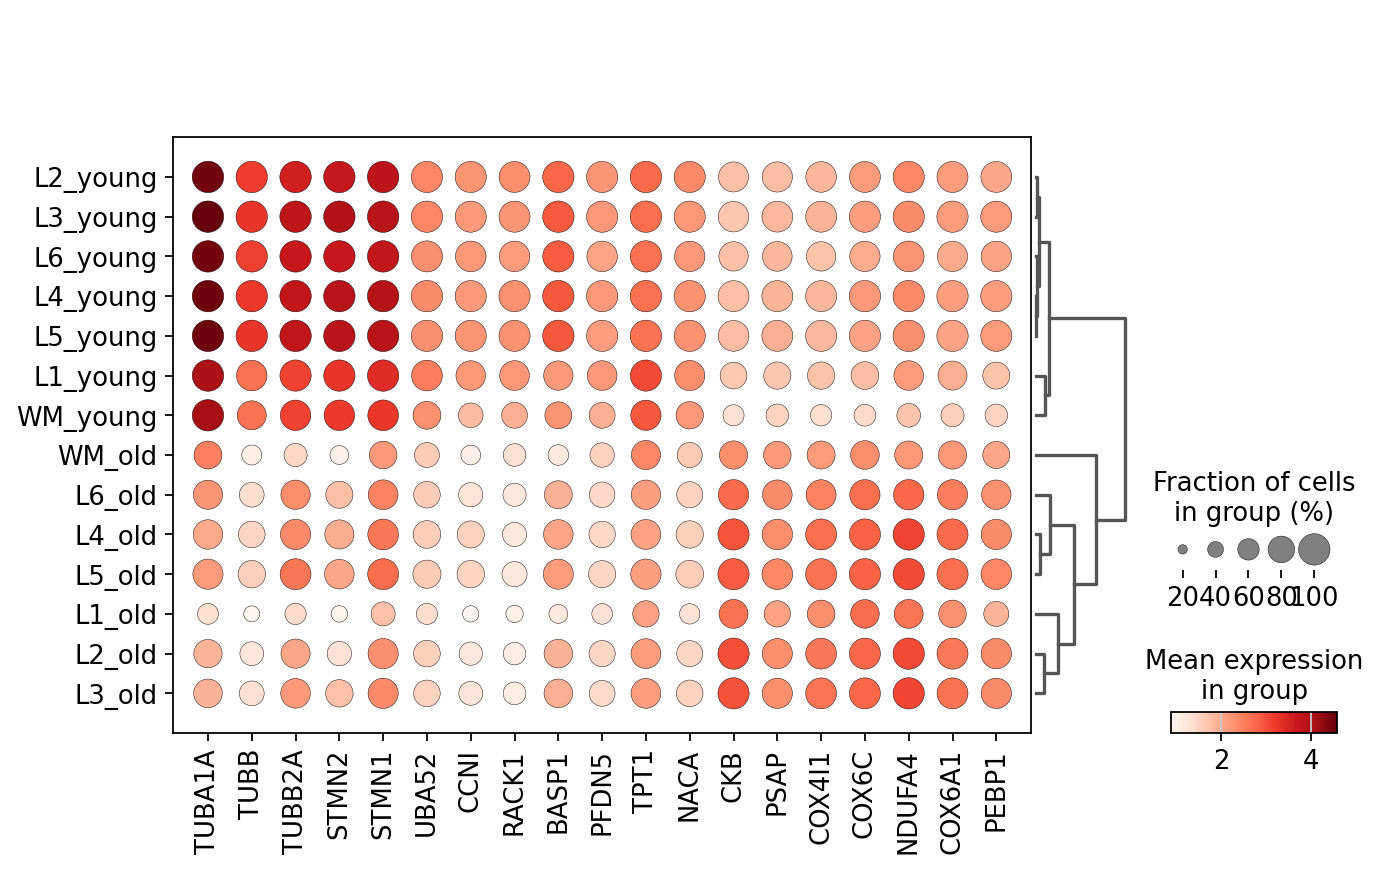

In [225]:
order = ["L1_young", "L2_young", "L3_young", "L4_young", "L5_young", "L6_young", "WM_young",
         "L1_old", "L2_old", "L3_old", "L4_old", "L5_old", "L6_old", "WM_old"]
sc.pl.dotplot(adata, pretty_genes_young + pretty_genes_old, groupby='label', categories_order=order, dendrogram=True)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_sample_id']`
categories: 151507, 151508, 151509, etc.
var_group_labels: L1_young


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


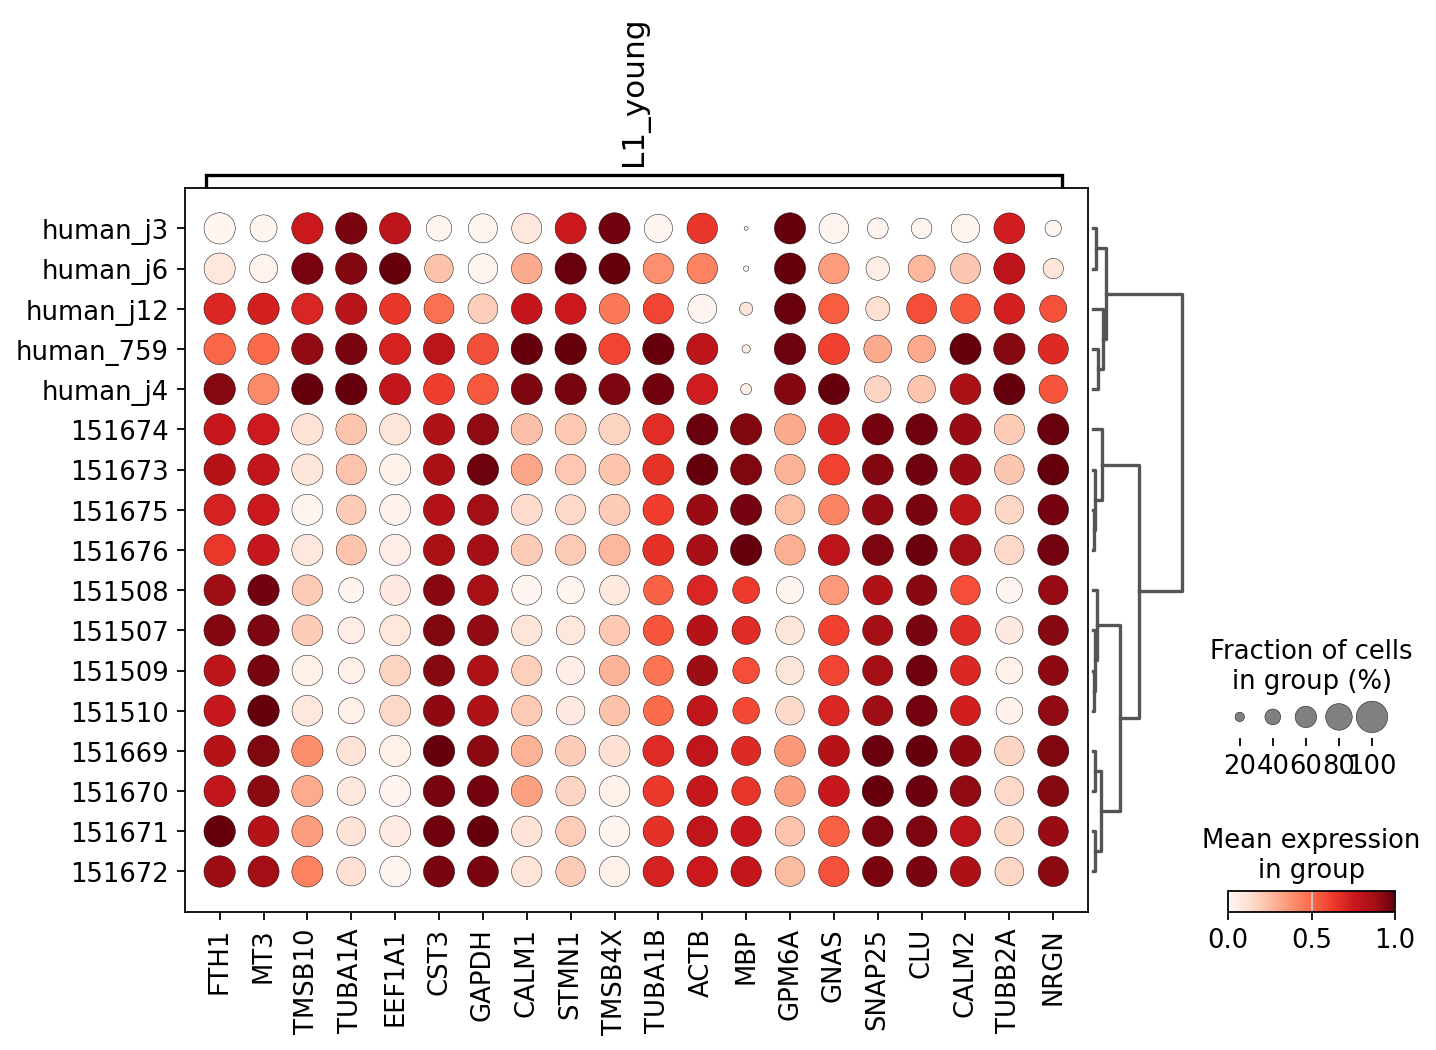

In [181]:
sc.pl.rank_genes_groups_dotplot(adata, groupby="sample_id", key='edgeR_L1_young', standard_scale='var', n_genes=20)

## Слоеспецифичные гены которые отличают молодых от взрослых

In [220]:
unique_degenes = dict()
for layer in edgeR_sign.keys():
    unique_layer_degenes = list(set(edgeR_sign[layer].index) - set(common_degenes))
    unique_degenes[layer] = unique_layer_degenes

In [ ]:
columns = adata.var.columns
sample_id_pct_columns = columns[(columns.str.contains("pct")) & (~columns.str.contains("L"))]
layer_pct_columns = columns[columns.str.contains("L")]

In [256]:
top_unique_genes = list()
for layer in sorted(edgeR_sign.keys()):
    col = layer_pct_columns
    mask = (adata.var[col].mean(axis=1) > 0.4)
    unique_highpct_genes = adata.var.loc[unique_degenes[layer]][mask].index
    top5genes = edgeR_sign[layer].loc[unique_highpct_genes].sort_values("logFC", key=np.abs, ascending=False).index.tolist()[:5]
    top_unique_genes += top5genes

<ipython-input-256-226fd5fb4afc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_highpct_genes = adata.var.loc[unique_degenes[layer]][mask].index
<ipython-input-256-226fd5fb4afc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_highpct_genes = adata.var.loc[unique_degenes[layer]][mask].index
<ipython-input-256-226fd5fb4afc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_highpct_genes = adata.var.loc[unique_degenes[layer]][mask].index
<ipython-input-256-226fd5fb4afc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_highpct_genes = adata.var.loc[unique_degenes[layer]][mask].index
<ipython-input-256-226fd5fb4afc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unique_highpct_genes = adata.var.loc[unique_degenes[layer]][mask].index
<ipython-input-256-226fd5fb4afc>:5: UserWarning: Boolean Series key wi

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


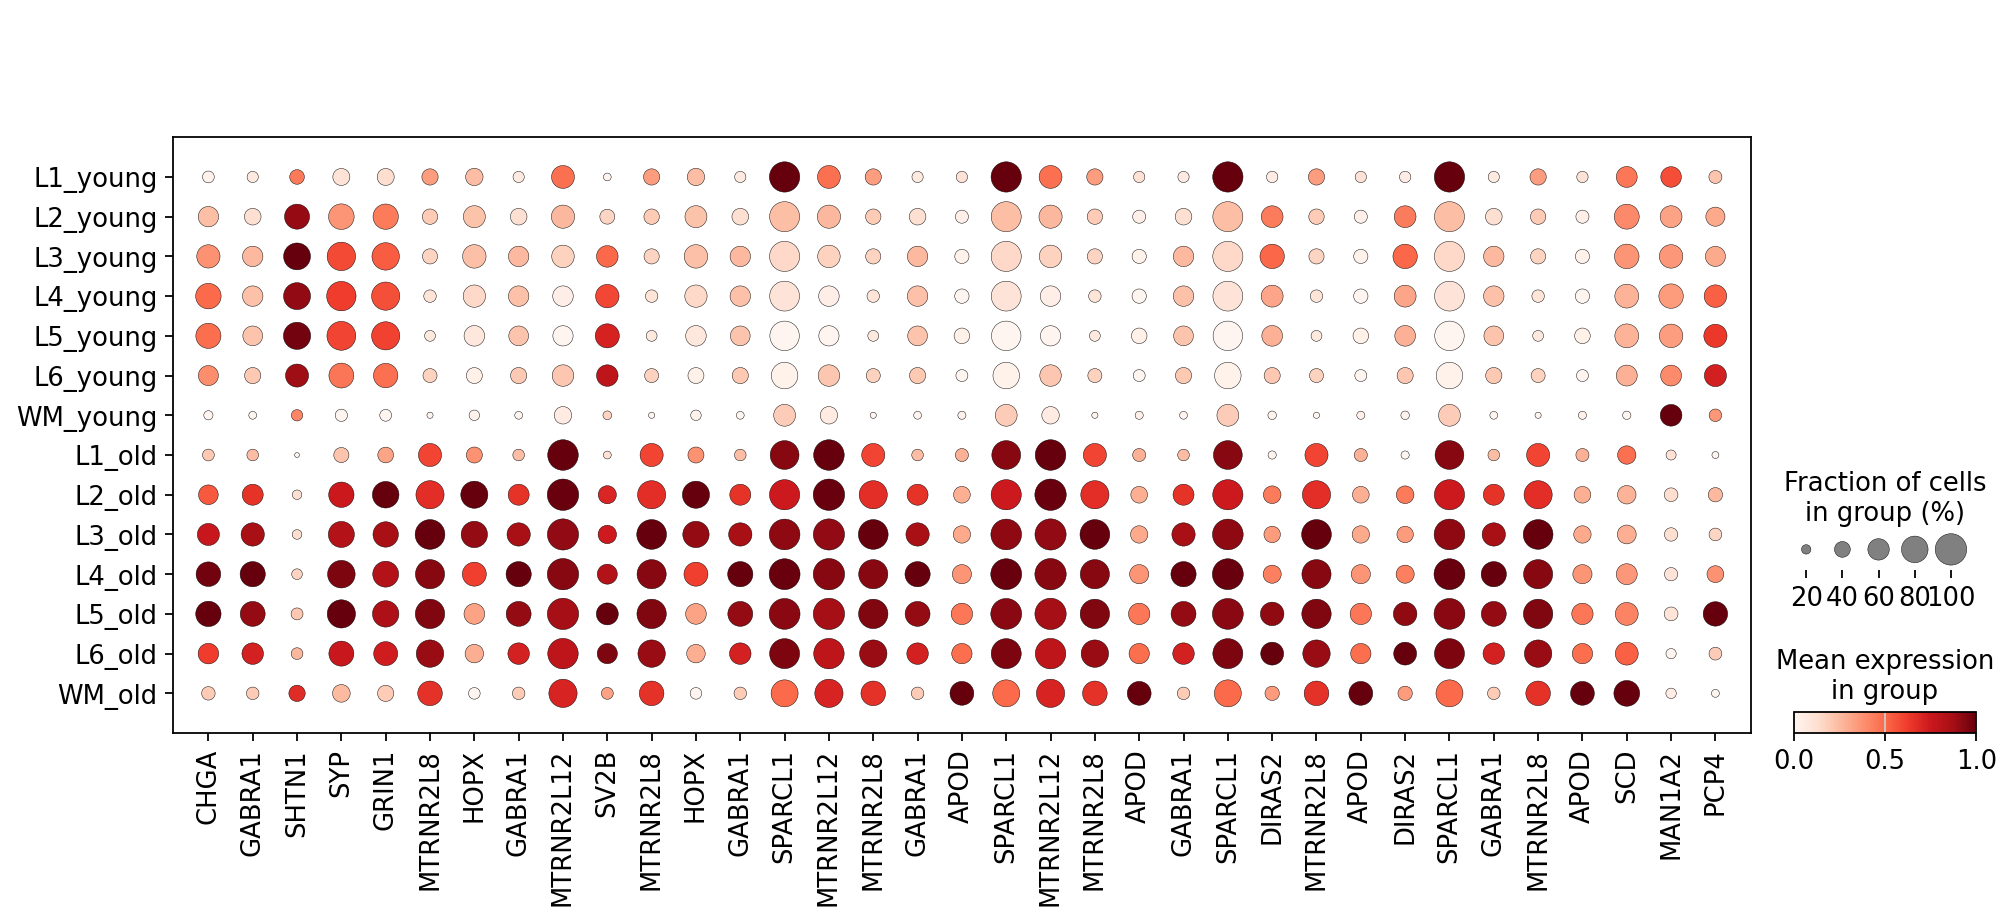

In [260]:
order = ["L1_young", "L2_young", "L3_young", "L4_young", "L5_young", "L6_young", "WM_young",
         "L1_old", "L2_old", "L3_old", "L4_old", "L5_old", "L6_old", "WM_old"]
sc.pl.dotplot(adata, top_unique_genes, groupby='label', categories_order=order, standard_scale='var')